#**SENTIMENT ANALYSIS USING RNN**


---



---




##Loading the Data

In [0]:
from google.colab import drive
from google.colab import files

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np

In [0]:
import tarfile
tar=tarfile.open("/content/drive/My Drive/NLP HW 3/aclImdb_v1.tar.gz", "r:gz")
tar.extractall()
tar.close()
#https://docs.python.org/3/library/tarfile.html

In [0]:
from os import listdir
pos_path_train="/content/aclImdb/train/pos/"
pos_files_train=[f for f in listdir(pos_path_train)]
neg_path_train="/content/aclImdb/train/neg/"
neg_files_train=[f for f in listdir(neg_path_train)]
pos_path_test="/content/aclImdb/test/pos/"
pos_files_test=[f for f in listdir(pos_path_test)]
neg_path_test="/content/aclImdb/test/neg/"
neg_files_test=[f for f in listdir(neg_path_test)]

In [0]:
#pos_train is the list of positive comments in training data
#same for neg.

pos_train=[]
for i in range(len(pos_files_train)):
    file=open("/content/aclImdb/train/pos/"+pos_files_train[i],"r", encoding='utf-8')
    input=file.read()
    pos_train.append(input)

neg_train=[]
for i in range(len(neg_files_train)):
    file=open("/content/aclImdb/train/neg/"+neg_files_train[i],"r", encoding='utf-8')
    input=file.read()
    neg_train.append(input)

pos_test=[]
for i in range(len(pos_files_test)):
    file=open("/content/aclImdb/test/pos/"+pos_files_test[i],"r", encoding='utf-8')
    input=file.read()
    pos_test.append(input)

neg_test=[]
for i in range(len(neg_files_test)):
    file=open("/content/aclImdb/test/neg/"+neg_files_test[i],"r", encoding='utf-8')
    input=file.read()
    neg_test.append(input)

So we have our data as lists in pos_train, neg_train, pos_test, neg_test.



---



---




##Exploratory Analysis

In [0]:
len(pos_train),len(neg_train),len(pos_test),len(neg_test)

(12500, 12500, 12500, 12500)

So we have eually divided training and test data sets with equal number of observations for each class.

In [0]:
#Now checking for review lengths in case of training and test data respectively
sent_len=[]
for sentence in pos_train:
    sent_len.append(len(sentence.split()))
for sentence in neg_train:
    sent_len.append(len(sentence.split()))

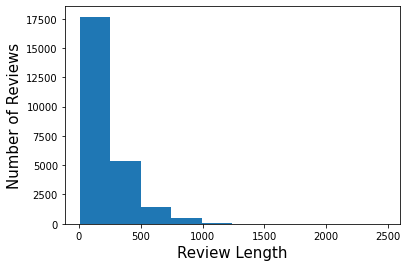

In [0]:
import matplotlib.pyplot as plt
plt.hist(sent_len)
plt.xlabel('Review Length',fontsize=15)
plt.ylabel('Number of Reviews',fontsize=15)
plt.show()

In [0]:
sent_len=[]
for sentence in pos_test:
    sent_len.append(len(sentence.split()))
for sentence in neg_test:
    sent_len.append(len(sentence.split()))

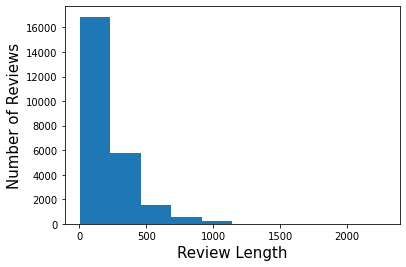

In [0]:
plt.hist(sent_len)
plt.xlabel('Review Length',fontsize=15)
plt.ylabel('Number of Reviews',fontsize=15)
plt.show()

Thus we observe that in the case of both training and test data, more than 50% reviews are of length less than 250. Some more in the range of 250-500. There are only very few reviews having length >500. Note that all of this is before preprocessing the data.

In [0]:
#Lets take a look at one of the file names
pos_files_train[0]

'1269_8.txt'

As in the decription of the data, the file name is of the form "uniqueID_score". Where score is the rating given for the particular review.

In [0]:
#Extracting the scores for positive and negative training data
pos_train_scores=[int(i.split("_")[1].split(".")[0]) for i in pos_files_train]
neg_train_scores=[int(i.split("_")[1].split(".")[0]) for i in neg_files_train]

In [0]:
set(pos_train_scores)

{7, 8, 9, 10}

Positive train data contains scores from 7 to 10.

In [0]:
pos_train_scores.count(7),pos_train_scores.count(8),pos_train_scores.count(9),pos_train_scores.count(10)

(2496, 3009, 2263, 4732)

The data for positive case is good as we have more of score 10 reviews compared to the other smaller scores.

In [0]:
set(neg_train_scores)

{1, 2, 3, 4}

Negative train data contains scores from 1 to 4.

In [0]:
neg_train_scores.count(1),neg_train_scores.count(2),neg_train_scores.count(3),neg_train_scores.count(4)

(5100, 2284, 2420, 2696)

The data for negative case is also good as we have more of score 1 reviews compared to the other greater scores.

In [0]:
#Extracting the scores for positive and negative test data
pos_test_scores=[int(i.split("_")[1].split(".")[0]) for i in pos_files_test]
neg_test_scores=[int(i.split("_")[1].split(".")[0]) for i in neg_files_test]

In [0]:
set(pos_test_scores)

{7, 8, 9, 10}

In [0]:
pos_test_scores.count(7),pos_test_scores.count(8),pos_test_scores.count(9),pos_test_scores.count(10)

(2307, 2850, 2344, 4999)

In [0]:
set(neg_test_scores)

{1, 2, 3, 4}

In [0]:
neg_test_scores.count(1),neg_test_scores.count(2),neg_test_scores.count(3),neg_test_scores.count(4)

(5022, 2302, 2541, 2635)

We have the similar conclusion for the test data also as the training one. 

In [0]:
#Now lets take a look at some of the text.
pos_train[10]

'It\'s hard to imagine a director capable of such godawful crap as \'Notting Hill\' pulling off something as sensitive and as attractive as this, but well, here\'s the evidence and it\'s quite compelling. Several have alluded to TV drama, and yes, this does have a seventies Play for Today feel at times, but is always a cut above, mainly I think owing to some quite superlative acting from Anne Reid and to a fine script which shadow-boxes with cliché without ever getting one on the nose, except maybe right at the end. (I didn\'t like either the tracking shot of indifferent goodbyes through the hallway, nor the oh-what-a-beautiful-morning final scene: she deserved a more studied finale than that I think, after all that hard work. The slippers business was a bit OTT too, on reflection).<br /><br />What I mean about avoiding cliché: well, I for one had a sinking expectation that the "mature" man May\'s daughter tries to set her up with would be cast in 2 dimensions as a repulsive old bore, 

We need to remove characters like "\\" and ensure that no space is added when we remove them. We will also replace the apostrophe sign without space because later I will use GLOVE embeddings to train and it has words like it's without the apostrophe (i.e. its)

In [0]:
pos_train[1000]

'this movie is practically impossible to describe. the alternate title "Don\'t Look Up" is a lot more descriptive. Like most Japanese cinema, the story is not as linear as American. The story revolves around a director who is filming a story about a ww2 deserter. The set is haunted(?) by an actress who died(?) during the filming of a tv show back in the 60s. the director is the ONLY one who saw this show. if you have seen Ringu (the director Hideo Nakata is the same) and liked it, you\'ll like ghost actress. i loved ghost actress a lot more than ringu. a truly scary and disturbing movie. a 10!'

Other non important characters like ")" can be removed and replaced by space

In [0]:
neg_train[90]

'In a way this is the disaster Fellini has been working towards all his life. The line between absurd masterpiece and free association bullshit is very small, and what category a film will ultimately fit in will often just depend on personal feelings. That said, "Casanova" left me in cold admiration for its sets and little more that cannot be summed up more adequately by Bukowski: <br /><br />"Casanova died too, just an old guy with a big cock and a long tongue and no guts at all. to say that he lived well is true; to say I could spit on his grave without feeling is also true. the ladies usually go for the biggest fool they can find; that is why the human race stands where it does today: we have bred the clever and lasting Casanovas, all hollow inside, like the Easter bunnies we foster upon our poor children." <br /><br />As far as I could make it out, this is the position Fellini takes regarding his subject; granted, with more empathy, but disgusted nonetheless.<br /><br />Casanova\'s

We also need to remove "\<br />\<br />" sort of stuff

Also other possibility that I observed was text like "xyz......pqr". This makes it necessary to ensure that . is replaced by space otherwise both words might get combined!



---



---




##Preprocessing

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Preprocessing the data to handle all the points discussed above. Also eliminating the stop words. Ignoring Lemmatization as GLOVE already has vectors for those words (Ex: bright brighter brightest). Note that I tried the complete thing with Lemmatization also and the results were almost the same. Also I tried keeping the stopwords thinking that they might lead to some symantic info but the results were comparitively worse than removing them.

In [0]:
stop_words=set(stopwords.words('english')) 

def preprocessing(lst):
    for i in range(len(lst)):
        temp=re.sub(r'[^a-zA-Z\'\\ ]+',' ',lst[i]) #Only leaving behind the alphabetical characters space and ' and \ marks.
        temp=re.sub(r'[\'\\]+','',temp) #Taking care of ' and \ marks
        temp=re.sub(r' br ','',temp) #Taking care of <br /><br />
        temp=temp.lower() #Converting the entire string to lower case.           
        words=word_tokenize(temp)
        words=[w for w in words if (w not in stop_words and len(w)>1)] #Removing stop words and single letter words
        temp=' '.join(words)
        lst[i]=temp
    return lst

pos_train=preprocessing(pos_train)
neg_train=preprocessing(neg_train)

pos_test=preprocessing(pos_test)
neg_test=preprocessing(neg_test)

So now we have the preprocessed data.



---



---



##Designing The RNN

The structure of the RNN I've used is shown below:-

$x_1,x_2,...x_n$ --> Inputs

$h_0,h_1,...h_n$ --> Hidden Layers

$s_i=tanh(h_i)$

$\hat{y}$ --> Expected Output

$W_{hy}, W_{xh}, W_{hh}$ --> Weights

$b_h, b_y$ --> Biases


![](https://drive.google.com/uc?id=1v1_sY6zpuAcb-VqjEB4aPG5f5p_FgRsK)

(I've made the Image using Libre Office)

The detailed explaination and derivation for forward and backward propagation can be accesssed via the following link to my file: 
https://drive.google.com/file/d/1EhNB83ZeilWQjIFc4le_S6uw1fFeItw1/view?usp=sharing


In [0]:
#The function names below stand for the work the function does

def softmax(x):
    z=np.exp(x)
    s=np.sum(z)
    return z/s

def tanh(x):
    return((2.0/(1+np.exp(-2*x)))-1.0)

Forward and Backward propagation algorithm below

In [0]:
def forward_prop(inputs,h): #inputs contains the various seq of inputs in proper format

    S_initial=np.zeros((h,1)) #the random S (say it corresponds to time 0 ...the other S start from time 1 and so on)
    S_saved={0:S_initial} #A dict with S corresponding to the times 0,1,2,... as the key
    #Note: We'll be saving the S at each time step, as it will be req during backprop along with the inputs 
    #(need not return the inputs here as they will be present in the function from where we called forward_prop)

    for i,X in enumerate(inputs):
        S_prev=S_saved[i]
        S=tanh(np.dot(Wxh.T,X)+np.dot(Whh.T,S_prev)+bh)
        S_saved[i+1]=S #Saving the S computed for next time step in the dict

    #At the last one, compute the output
    y=np.dot(Why.T,S_saved[len(inputs)])+by #Here, the S will be the last computed one
    return S_saved,y

def backward_prop(S_saved,inputs_saved,y,correct_class,alpha): #alpha=learning rate

    global Why,by,Wxh,Whh,bh

    #Initial zero values for these derivatives of weights and biases (will be updated below)
    dL_dWhy=np.zeros(Why.shape)
    dL_dby=np.zeros(by.shape)
    dL_dWxh=np.zeros(Wxh.shape)
    dL_dWhh=np.zeros(Whh.shape)
    dL_dbh=np.zeros(bh.shape)

    p=softmax(y)
    dL_dy=p[:]
    dL_dy[correct_class]=dL_dy[correct_class]-1
    #dL/dy = pi if i <> c else = pi-1 if i = c

    n=len(inputs_saved)

    dL_dWhy=np.dot(S_saved[n],dL_dy.T)
    #dL/dWhy = dL/dy * Sn
    
    dL_dby=dL_dy
    #dL/dby=dL/dy

    #The above ones were easy. Difficult ones below

    dL_dS=np.dot(Why,dL_dy) #For nth S(i.e. the last) ...dL/dSn=dL/dy*dy/dSn ...dy/dSn=Why    
    
    for i in range(n,0,-1): #In the reverse order
          
        common_term=1-S_saved[i]**2 #This term will appear in all the remaining derivatives

        common_term=common_term*dL_dS

        dL_dWxh+=np.dot(inputs_saved[i-1],common_term.T)
        #dL/dWxh=sum(dL/dS[t] * [ (1-S[t])^2 * Xt ])

        dL_dWhh+=np.dot(S_saved[i-1],common_term.T)
        #dL/dWhh=sum(dL/dS[t] * [ (1-S[t])^2 * S[t-1] ])

        dL_dbh+=common_term
        #dL/dbh=sum(dL/dS[t] * (1-S[t])^2)

        dL_dS=np.dot(Whh,common_term)
        #dL/dS[i-1]=dL/dS[i] * [ (1-S[i])^2 * Whh ]

    #Gradient clipping to handle exploding gradients.
    np.clip(dL_dWhy, -1, 1, out=dL_dWhy)
    #Updating weights
    Why-=alpha*dL_dWhy

    np.clip(dL_dby, -1, 1, out=dL_dby)
    by-=alpha*dL_dby
        
    np.clip(dL_dWxh, -1, 1, out=dL_dWxh)
    Wxh-=alpha*dL_dWxh
        
    np.clip(dL_dWhh, -1, 1, out=dL_dWhh)
    Whh-=alpha*dL_dWhh
    
    np.clip(dL_dbh, -1, 1, out=dL_dbh)
    bh-=alpha*dL_dbh

    #So weights and biases updated

Using GloVe to pass inputs to the RNN.

In [0]:
from zipfile import ZipFile 
file_name="/content/drive/My Drive/NLP HW 3/glove.6B.300d.zip"
with ZipFile(file_name, 'r') as zip: 
    zip.extractall() 

#Creating a GLOVE embeddings dictionary
#https://github.com/stanfordnlp/GloVe
#Taken the Wiki 6B tokens pre trained word vectors of 300 dimension

embeddings_dict={}
with open("glove.6B.300d.txt", 'r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:], "float32")
        embeddings_dict[word]=vector

In [0]:
def createInputs(text):
  #Returns the GLOVE vectors corresponding to each of the words in the text 
  inputs=[]
  for w in text.split(' '):
    if(w in embeddings_dict):
        v=embeddings_dict[w]
        v.shape=[300,1]
        inputs.append(v)
  return inputs

I had one more idea of taking bigrams for passing as input. I took the GloVe embeddings as the average for the bigrams. This gave a bit better result sometimes. But the difference was very small. So we will go with the normal way of passing input.

In [0]:
def train(h,epochs,alpha):
    #Initial Values of weights and biases
    global Why,by,Wxh,Whh,bh
    i= 300 # i = input layer size
    o= 2 # op = output layer size
    # h = hidden layer size


    #We can make use of Xaviers inititalization technique for weights 
    #but partially based on that and intuitively we can set the initial weights as follows
    #because most of our input length would be around 250
    Wxh=np.random.uniform(-0.9,0.9,(i,h))/250
    Why=np.random.uniform(-0.9,0.9,(h,o))/250
    Whh=np.random.uniform(-0.9,0.9,(h,h))/250
    #We initialize the bias values to zeroes as initially we don't have any bias
    bh=np.zeros((h,1))
    by=np.zeros((o,1))

    len_train=len(pos_train)+len(neg_train)

    #epochs=20
    #alpha=0.01

    #Early stopping parameters
    #To make the training stop early based on some criterion(if required)
    temp=100
    f=0

    print("Training has begun...\n")

    #Learning i.e forward and backward propagation invoked below
    for i in range(0,epochs):
        
        loss=0
        acc_count=0

        for j in range(len(pos_train)):

            inputs=createInputs(pos_train[j])

            S_saved,y=forward_prop(inputs,h) #inputs contains the various seq of inputs in proper format

            correct_class=1

            loss=-np.log(softmax(y)[correct_class]) #Cross entropy loss

            if(np.argmax(softmax(y))==1):
                acc_count+=1

            backward_prop(S_saved,inputs,y,correct_class,alpha) #alpha=learning rate


            inputs=createInputs(neg_train[j])

            S_saved,y=forward_prop(inputs,h) #inputs contains the various seq of inputs in proper format

            correct_class=0

            loss=-np.log(softmax(y)[correct_class])

            if(np.argmax(softmax(y))==0):
                acc_count+=1

            backward_prop(S_saved,inputs,y,correct_class,alpha) #alpha=learning rate
        
        #Early Stopping
        if(loss>temp or np.abs(loss-temp)<0.00001):
            f+=1
        else:
            f=0 #to reset counter if it again decreases
        
        temp=loss
        
        print("Loss: ",loss)

        acc=acc_count*100/len_train

        print("Accuracy: ",acc)
        print("\n")

        #In case loss increases for 3 continuous epochs or there is hardly any change then stop
        if(f==3):
            break
    
    print("\nTesting has begun...\n")

    test(h)


In [0]:
def test(h):
  
    count=0 #To store count of correct classifications

    for j in range(len(pos_test)):

            inputs=createInputs(pos_test[j])

            S_saved,y=forward_prop(inputs,h) #inputs contains the various seq of inputs in proper format

            if(np.argmax(softmax(y))==1):
                count+=1

    for j in range(len(neg_test)):

            inputs=createInputs(neg_test[j])

            S_saved,y=forward_prop(inputs,h) #inputs contains the various seq of inputs in proper format

            if(np.argmax(softmax(y))==0):
                count+=1

    print("Test Accuracy = ",count*100/(len(pos_test)+len(neg_test)))

The paramters for training are h, epochs, alpha i.e the hidden layer size, epochs, and the learning rate respectively



---



---



##Training and Testing

After a lot of training and testing, I've come up with the following hyperparameters to give the best results. A few more results are shown below that. Note that I've tried the training and testing for a lot more combinations of hyperparameters than the one below. But I've only shown a few here.

In [0]:
train(h=20,epochs=30,alpha=0.005)

Training has begun...

Loss:  [0.69325396]
Accuracy:  0.108


Loss:  [0.6931828]
Accuracy:  28.508


Loss:  [0.69180188]
Accuracy:  56.704


Loss:  [0.62917666]
Accuracy:  59.532


Loss:  [0.56592648]
Accuracy:  70.512


Loss:  [0.26132231]
Accuracy:  77.648


Loss:  [0.34904676]
Accuracy:  78.132


Loss:  [0.31843654]
Accuracy:  78.052


Loss:  [0.28516991]
Accuracy:  78.676


Loss:  [0.26267135]
Accuracy:  78.524


Loss:  [0.30058682]
Accuracy:  78.704


Loss:  [0.26431629]
Accuracy:  78.92


Loss:  [0.21115869]
Accuracy:  79.088


Loss:  [0.25152723]
Accuracy:  79.376


Loss:  [0.22107362]
Accuracy:  79.532


Loss:  [0.24544472]
Accuracy:  79.78


Loss:  [0.17260871]
Accuracy:  79.724


Loss:  [0.16356832]
Accuracy:  79.648


Loss:  [0.14281092]
Accuracy:  79.88


Loss:  [0.11966811]
Accuracy:  80.0


Loss:  [0.14883818]
Accuracy:  80.096


Loss:  [0.12968356]
Accuracy:  80.216


Loss:  [0.12777341]
Accuracy:  80.216


Loss:  [0.12951464]
Accuracy:  80.344


Loss:  [0.12365823]
Accu

We get a training accuracy of 80.7% and a test accuracy of 79.8%. (You might have to scroll down the above output to view the test accuracy)

In [0]:
#Trying to do grid search to find comparitively better values of h and alpha
#Note that these involved stricter early stopping criteria than the one above

for h in [5,10,20,50]:
    for alpha in [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]:
        
        print("h = ",h,"\nalpha = ",alpha,"\n")
        train(h=h,epochs=50,alpha=alpha)
        print("\n _________________________________________________________ \n")


h =  5 
alpha =  0.1 

Training has begun...

Loss:  [0.71139843]
Accuracy:  52.376


Loss:  [1.7738276]
Accuracy:  58.808


Loss:  [1.81867172]
Accuracy:  60.408



Testing has begun...

Test Accuracy =  65.812

 _________________________________________________________ 

h =  5 
alpha =  0.05 

Training has begun...

Loss:  [1.0283157]
Accuracy:  59.928


Loss:  [1.41743448]
Accuracy:  65.788


Loss:  [1.05428875]
Accuracy:  68.152


Loss:  [0.28443943]
Accuracy:  67.708


Loss:  [1.13051912]
Accuracy:  68.624


Loss:  [1.11396855]
Accuracy:  69.388


Loss:  [1.17267521]
Accuracy:  69.56


Loss:  [0.11640601]
Accuracy:  69.224


Loss:  [1.69979339]
Accuracy:  70.848


Loss:  [2.03044222]
Accuracy:  71.392



Testing has begun...

Test Accuracy =  72.84

 _________________________________________________________ 

h =  5 
alpha =  0.01 

Training has begun...

Loss:  [0.38867429]
Accuracy:  59.136


Loss:  [0.34158998]
Accuracy:  72.88


Loss:  [0.24058686]
Accuracy:  75.076


Loss:  

Apart from the above, we can also do a bit more preprocessing. This will involve removing the less frequent words (say taking all words whose frequency in the entire text is more than 50). I've also shown that below. It sometimes led to about 1% increase in accuracy (But taking words whose freq>100 led to the similar or less accuracy). But thats not very much considering the fact that neural nets can get trained in different ways every time. Also choice of this number (50) is very biased (based on the data). So if we are getting the similar accuracy without this preprocessing, then we shouldn't worry much about it.

In [0]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist

combined_str=(" ".join(pos_train))+(" ".join(neg_train)) #Combining all strings into one.                    

words=word_tokenize(combined_str)
cfdist=FreqDist(words)

In [0]:
tokens=set()
for w in words:
    if(cfdist[w]>50): #Take all words whose freq > 50
        tokens.add(w)


In [0]:
def createInputs(text):
  #The same as before just with a check for word in tokens or not
  inputs=[]
  for w in text.split(' '):
    if(w in embeddings_dict and w in tokens):
        v=embeddings_dict[w]
        v.shape=[300,1]
        inputs.append(v)
  return inputs

In [0]:
train(h=20,epochs=40,alpha=0.005)

Training has begun...

Loss:  [1.56105685]
Accuracy:  49.568


Loss:  [0.19262998]
Accuracy:  73.66


Loss:  [0.22237042]
Accuracy:  75.44


Loss:  [0.32196493]
Accuracy:  75.576


Loss:  [0.18680813]
Accuracy:  76.888


Loss:  [1.71801747]
Accuracy:  76.668


Loss:  [0.27449335]
Accuracy:  76.956


Loss:  [0.62961238]
Accuracy:  77.332


Loss:  [0.86284827]
Accuracy:  78.064


Loss:  [0.86123064]
Accuracy:  78.196


Loss:  [0.76497505]
Accuracy:  79.324


Loss:  [0.54380779]
Accuracy:  78.908


Loss:  [0.3205685]
Accuracy:  78.676


Loss:  [0.12292897]
Accuracy:  78.62


Loss:  [0.31417054]
Accuracy:  78.84


Loss:  [0.1760929]
Accuracy:  79.556


Loss:  [0.05627441]
Accuracy:  79.604


Loss:  [0.09410214]
Accuracy:  78.84


Loss:  [0.36293672]
Accuracy:  79.836


Loss:  [0.04828335]
Accuracy:  79.884


Loss:  [0.48108264]
Accuracy:  79.964


Loss:  [0.32584473]
Accuracy:  80.1


Loss:  [1.26503827]
Accuracy:  80.324


Loss:  [0.05949451]
Accuracy:  80.5


Loss:  [0.67925149]
Accuracy

So we get a training accuracy of 81% and a test accuracy of 80.5%

There is one more way that may seem not to work but actually worked better than this one. It is taking the individual sentences in a review as a combined vector of words - the average of the GloVe vectors for each word in that sentence. The advantage may be that it would be very fast and be able to learn better. But the disadvantage is that the order of words is not preserved. This is the thing that RNN specializes in. The method is shown below.

In [0]:
def createInputs(text):
  #Returns the average of GLOVE vectors for the sentences in the review 
  inputs=[]
  for sentence in re.split('[.?!]+',text):
      temp=np.zeros((300,1))
      len=0
      for w in sentence.split(' '):
          if(w in embeddings_dict):
              v=embeddings_dict[w]
              v.shape=[300,1]
              temp+=v
              len+=1
      if(len>0):
          inputs.append(temp/len)
  return inputs

In [0]:
#Grid search for best hyperparameters
for h in [5,10,20]:
    for alpha in [0.1,0.05,0.01,0.005,0.001,0.0001]:
        print("h = ",h,"\nalpha = ",alpha,"\n")
        train(h=h,epochs=40,alpha=alpha)
        print("\n _________________________________________________________ \n")

h =  5 
alpha =  0.1 

Training has begun...

Loss:  [0.20087626]
Accuracy:  49.728


Loss:  [0.54937452]
Accuracy:  64.244


Loss:  [0.22720234]
Accuracy:  64.432


Loss:  [0.1775706]
Accuracy:  65.076


Loss:  [0.15365852]
Accuracy:  67.836


Loss:  [0.09890166]
Accuracy:  66.272


Loss:  [0.04764218]
Accuracy:  67.148


Loss:  [0.61974319]
Accuracy:  64.176


Loss:  [0.12867393]
Accuracy:  69.376


Loss:  [0.04756756]
Accuracy:  66.612


Loss:  [0.15844039]
Accuracy:  69.872


Loss:  [0.08370072]
Accuracy:  71.56


Loss:  [0.23445456]
Accuracy:  72.332


Loss:  [0.09952273]
Accuracy:  72.436


Loss:  [0.46848572]
Accuracy:  73.06


Loss:  [0.30878677]
Accuracy:  73.408


Loss:  [0.6402406]
Accuracy:  72.156


Loss:  [0.05566866]
Accuracy:  73.472


Loss:  [0.29056602]
Accuracy:  73.02


Loss:  [0.23854305]
Accuracy:  73.336


Loss:  [0.36903676]
Accuracy:  68.84


Loss:  [0.532831]
Accuracy:  72.296


Loss:  [0.1075567]
Accuracy:  74.728


Loss:  [0.07695135]
Accuracy:  71.612


Los

If you scroll down in the above outputs you'll find that for h = 10 and learning rate = 0.01 we obtain a training accuracy of 83.72% and a test accuracy of 82.93%. Thus, surprisingly, this method works better for the IMDB dataset somehow.



---



---



##Conclusion

**We have mostly achieved a training and test accuracy of around 80%. Highest being 83.7% and 82.9% respectively.** 

According to me, I've tried on several combinations of hyperparameters, but there could still be some which might lead to increase in accuracy. For inputs, GloVe led to the best accuracy. Passing the one-hot vectors of words or characters, or taking the one-hot vectors of the shortened vocabulary were either leading to low accuracy or were infeasable due to obvious reasons. 



---



---

